In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
kundanbedmutha_market_trend_and_external_factors_dataset_path = kagglehub.dataset_download('kundanbedmutha/market-trend-and-external-factors-dataset')

print('Data source import complete.')


100%|██████████| 977k/977k [00:00<00:00, 39.2MB/s]

Extracting files...
Data source import complete.


<img src="https://devra.ai/analyst/notebook/3750/image.jpg" style="width: 100%; height: auto;" />

<div style="text-align:center; border-radius:15px; padding:15px; color:white; margin:0; font-family: 'Orbitron', sans-serif; background: #2E0249; background: #11001C; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.3); overflow:hidden; margin-bottom: 1em;">
  <div style="font-size:150%; color:#FEE100"><b>Market Trend and External Factors Analysis Notebook</b></div>
  <div>This notebook was created with the help of <a href="https://devra.ai/ref/kaggle" style="color:#6666FF">Devra AI</a></div>
</div>

This notebook embarks on a journey to explore market trends in conjunction with external economic and geopolitical factors. The dataset provides an extensive list of features including market prices, volume, daily returns, and various sentiment indicators. If you find this analysis helpful, please consider upvoting it.

## Table of Contents

[Imports and Setup](#Imports-and-Setup)

[Data Loading and Preprocessing](#Data-Loading-and-Preprocessing)

[Visualization and Analysis](#Visualization-and-Analysis)

[Predictive Modeling](#Predictive-Modeling)

[Summary and Future Work](#Summary-and-Future-Work)

In [2]:
# Imports and Setup
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')  # Ensuring non-GUI backend
import matplotlib.pyplot as plt
plt.switch_backend('Agg')  # If only plt is referenced

import seaborn as sns
sns.set(style='whitegrid')

import math

%matplotlib inline

# For predictive modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

print('Imports and setup complete.')

Imports and setup complete.


In [4]:
# Data Loading and Preprocessing
import os

# Construct the correct file path using the downloaded dataset path
file_path = os.path.join(kundanbedmutha_market_trend_and_external_factors_dataset_path, 'Market_Trend_External.csv')

df = pd.read_csv(file_path, encoding='ascii', delimiter=',')

# Convert the 'Date' column to datetime. This is important for time-series analysis and ensuring proper date operations.
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Examine the first few rows to ensure data is loaded correctly
print('Data loaded. Here are the first 5 rows:')
print(df.head())

# Check data types and non-null counts
print('Data info:')
print(df.info())

Data loaded. Here are the first 5 rows:
        Date  Open_Price  Close_Price  High_Price  Low_Price    Volume  \
0 1902-09-08      100.00       100.50      100.63      99.35   2334489   
1 1902-09-09      100.50       102.02      102.30      99.49  10626850   
2 1902-09-10      102.02       101.55      102.56     101.09   9884633   
3 1902-09-11      101.55       101.08      104.16     100.13   9405648   
4 1902-09-12      101.08        98.65      101.69      98.39   5247581   

   Daily_Return_Pct  Volatility_Range  VIX_Close  Economic_News_Flag  \
0            0.0000              1.28      31.44                   0   
1            1.5124              2.81      27.99                   1   
2           -0.4607              1.47      21.27                   1   
3           -0.4628              4.03      48.86                   1   
4           -2.4040              3.30      15.78                   1   

   Sentiment_Score  Federal_Rate_Change_Flag  GeoPolitical_Risk_Score  \
0        

Total numeric columns found: 13


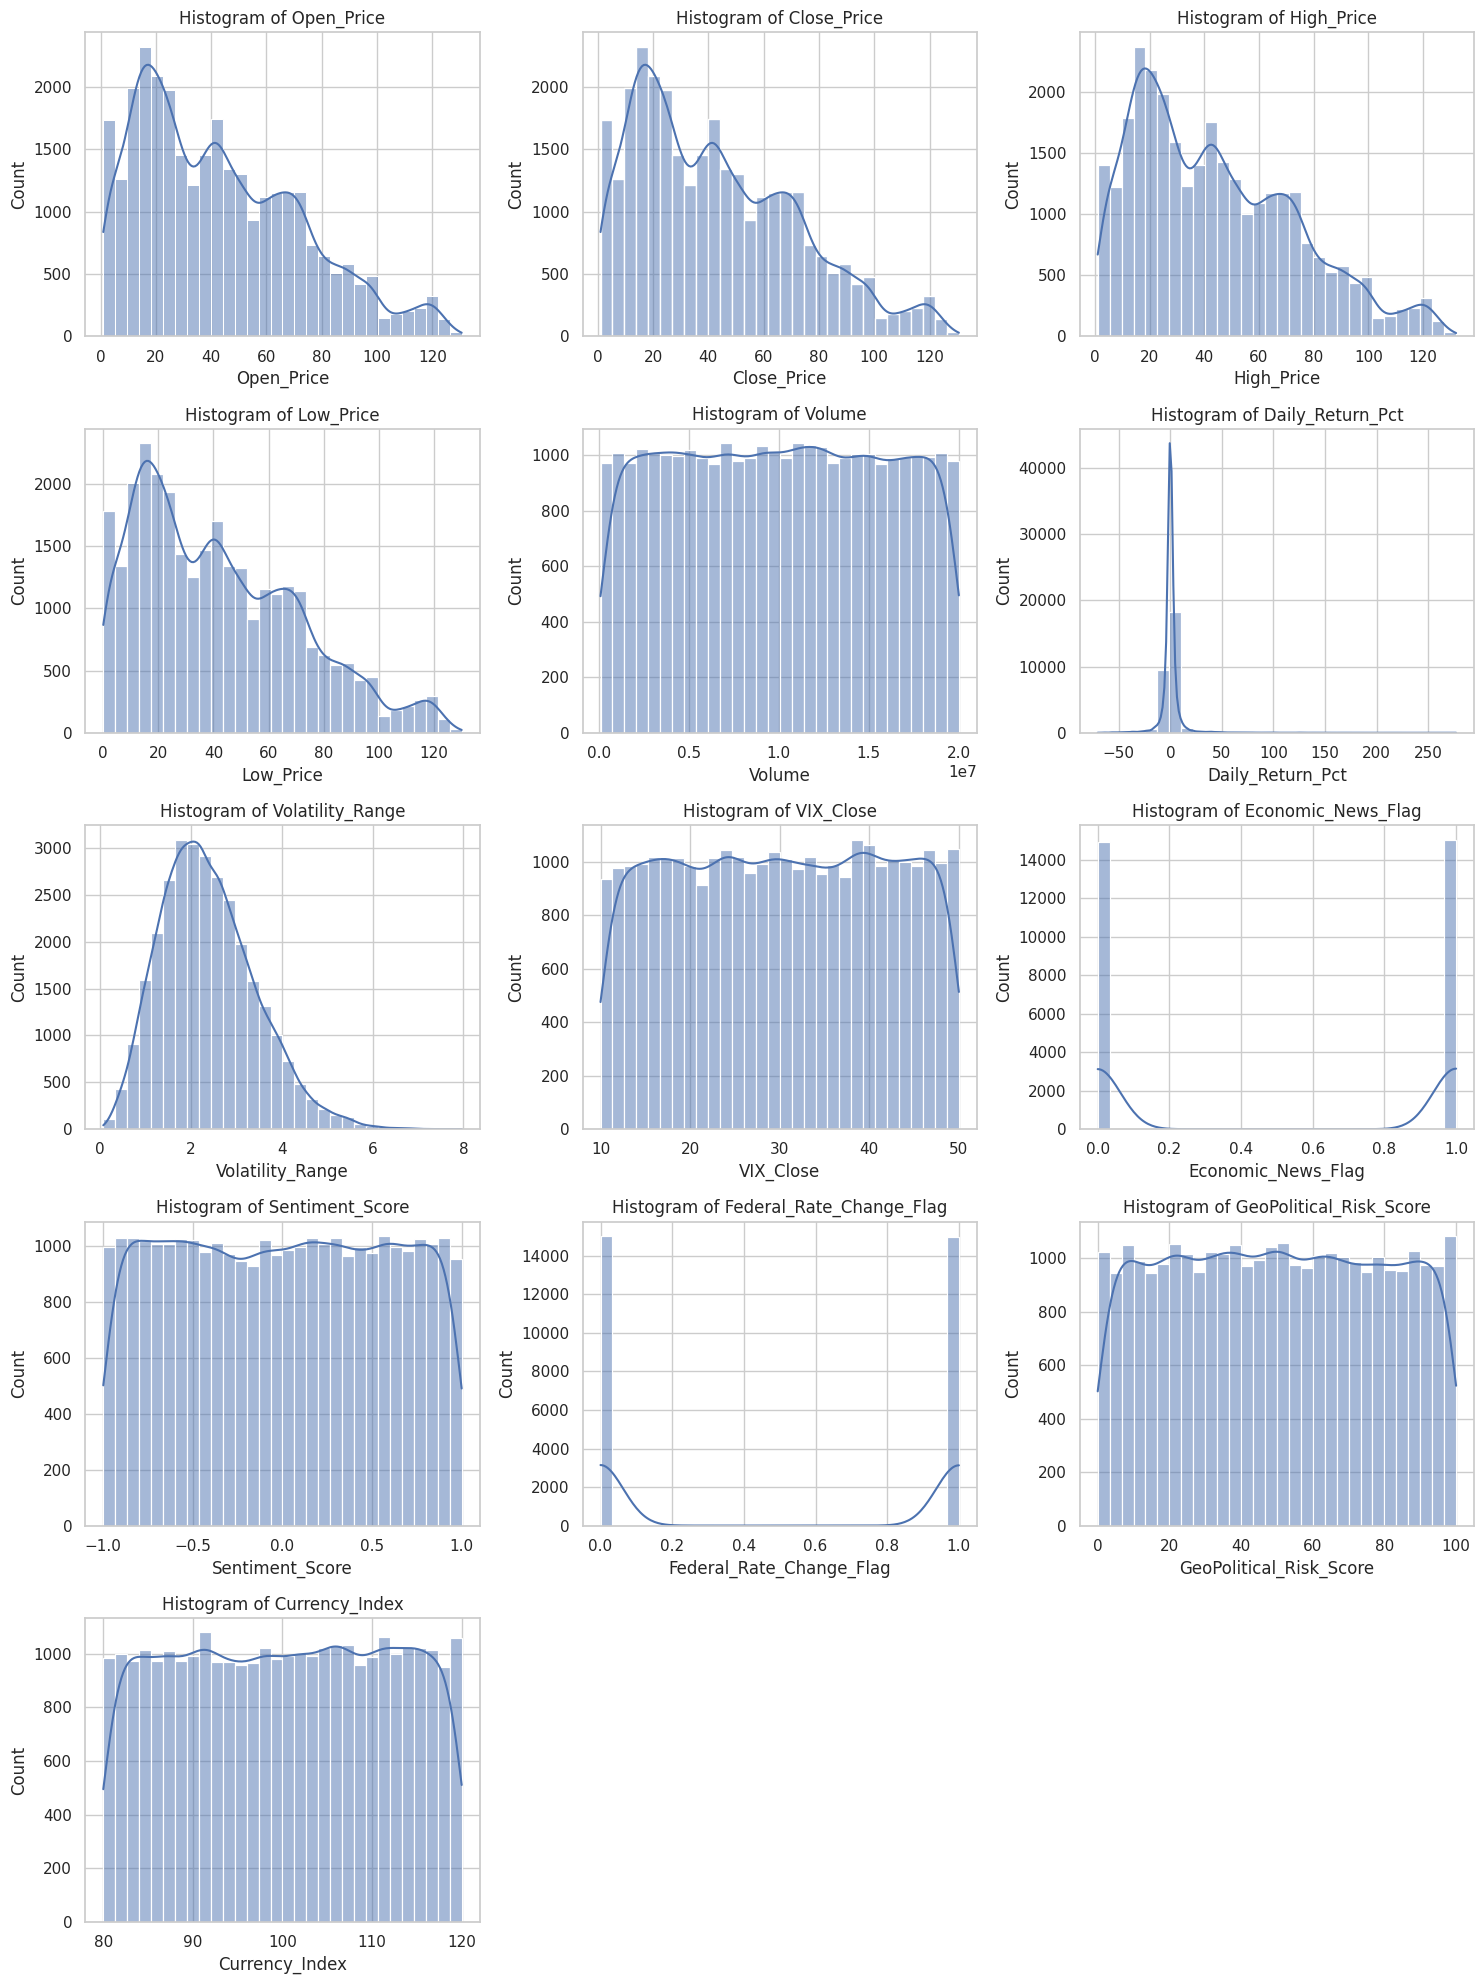

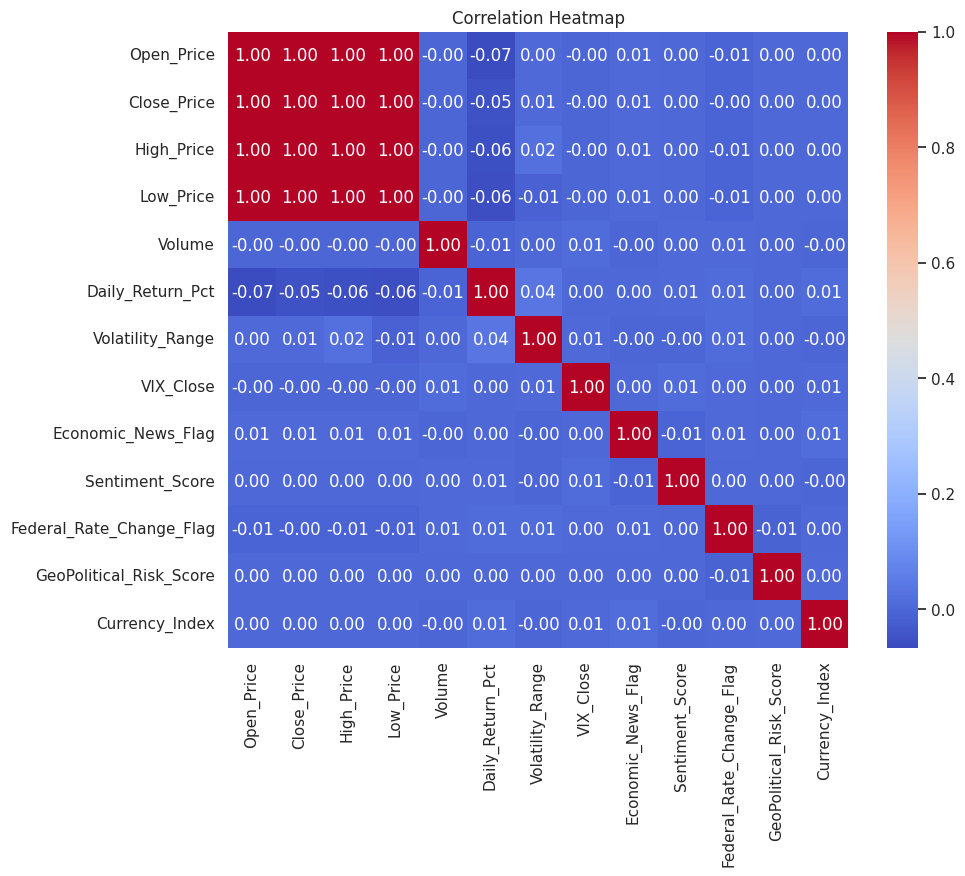

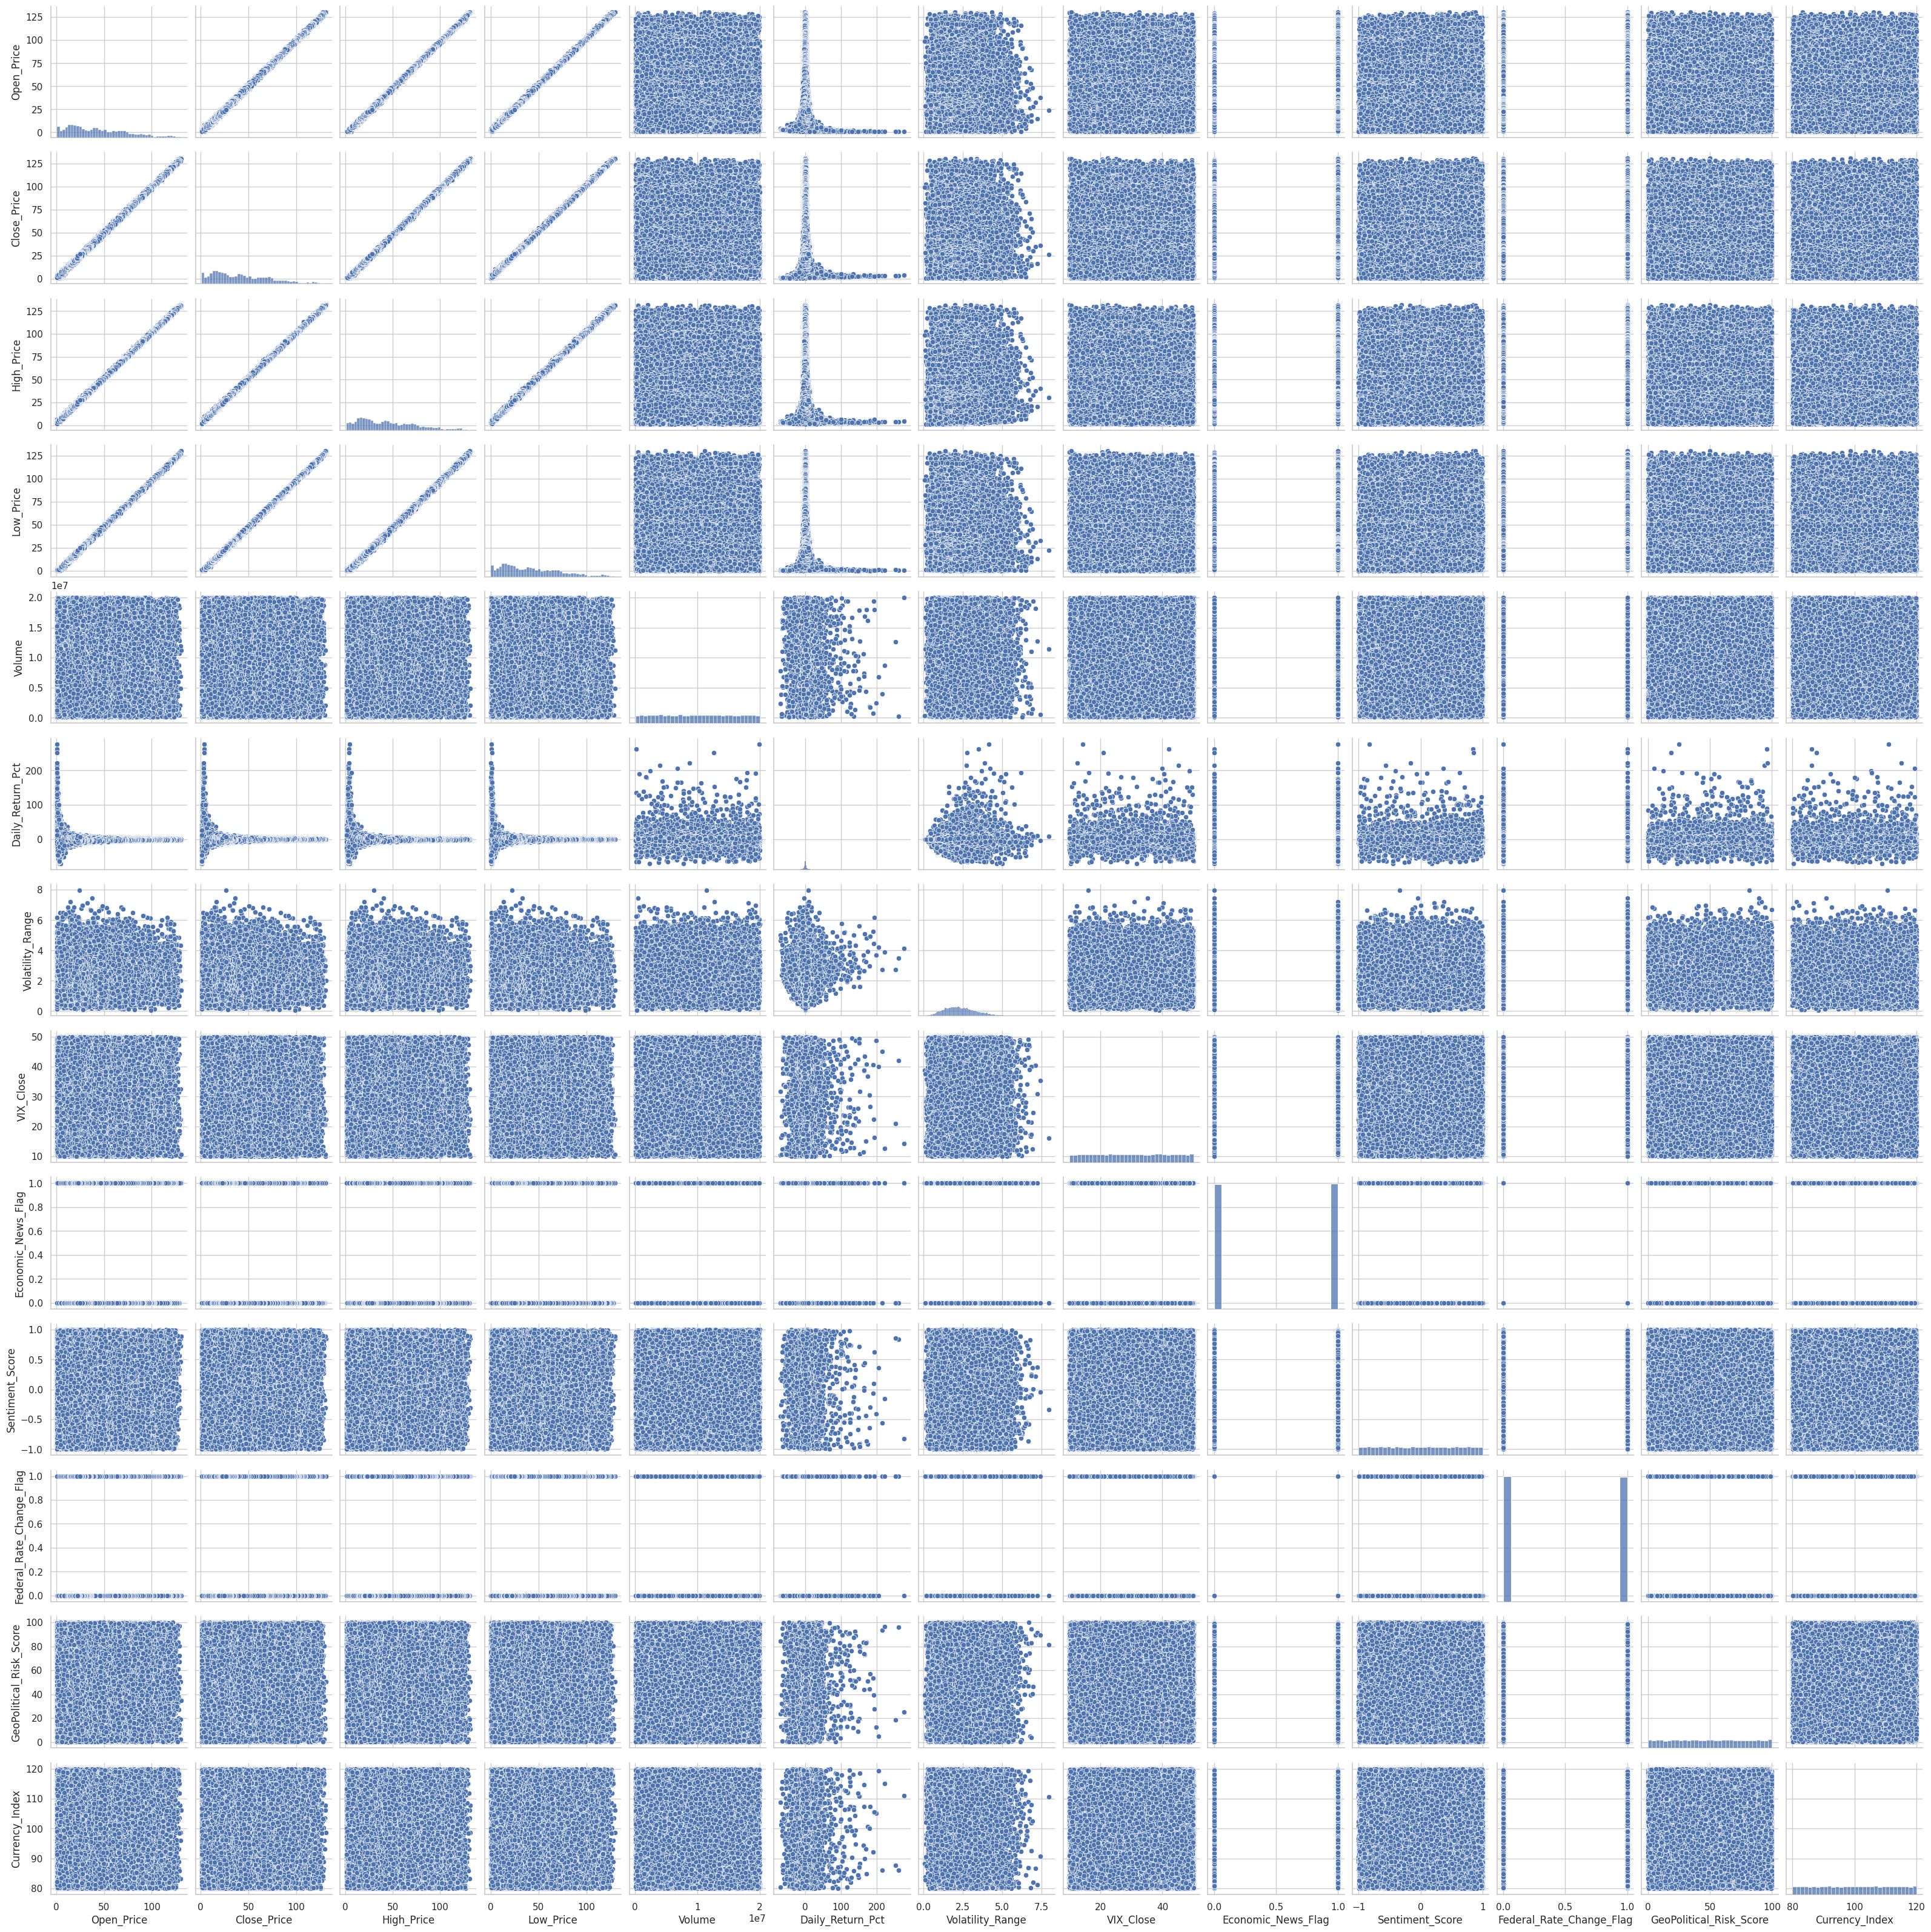

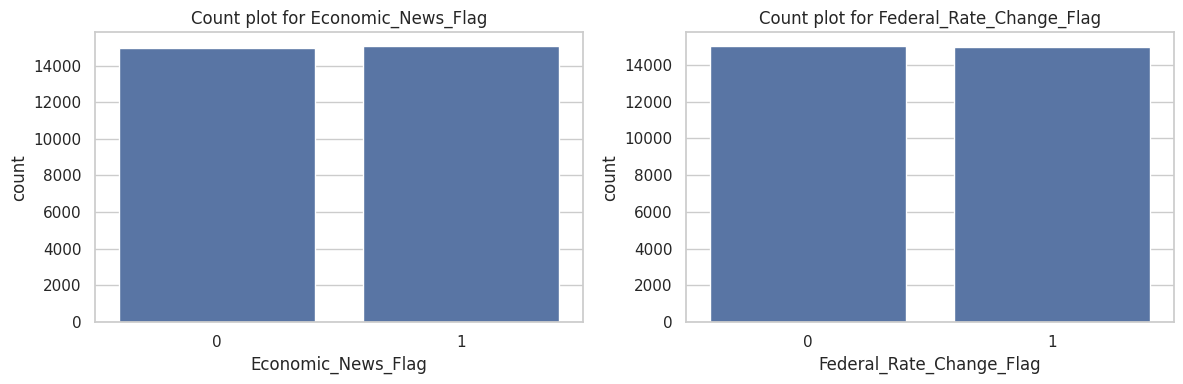

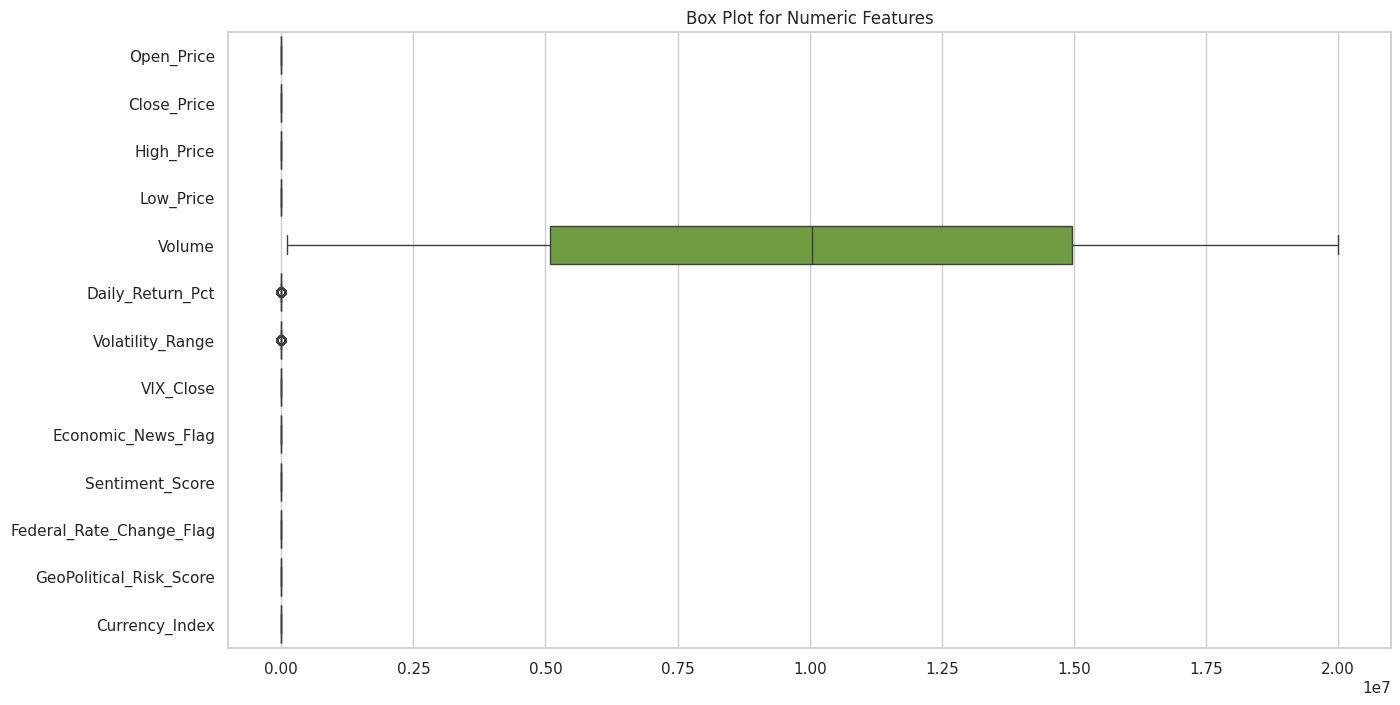

In [5]:
# Visualization and Analysis
# The following cell produces multiple visualizations:
# 1. Histograms for each numeric variable with a dynamic grid layout (to avoid the subplot index error encountered earlier).
#    Previously, a fixed 4x3 grid was used which led to errors when there were more than 12 numeric columns.
# 2. Correlation heatmap (only if there are 4 or more numeric columns).
# 3. Pair plots to observe relationships among numeric features.
# 4. Count plots for the categorical-like features: Economic_News_Flag and Federal_Rate_Change_Flag.
# 5. Box plot for detecting outliers in numeric features.

# Extract numeric columns from the dataframe
numeric_df = df.select_dtypes(include=[np.number])
numeric_cols = numeric_df.columns.tolist()

print(f'Total numeric columns found: {len(numeric_cols)}')

# Determine dynamic grid size based on number of numeric columns
ncols = 3  # Number of columns in the grid
nrows = math.ceil(len(numeric_cols) / ncols)

plt.figure(figsize=(5 * ncols, 4 * nrows))
for idx, col in enumerate(numeric_cols):
    ax = plt.subplot(nrows, ncols, idx + 1)
    sns.histplot(numeric_df[col], kde=True, bins=30, ax=ax)
    ax.set_title(f'Histogram of {col}')
    plt.tight_layout()
plt.show()

# Correlation Heatmap if there are 4 or more numeric columns
if len(numeric_cols) >= 4:
    plt.figure(figsize=(10, 8))
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()

# Pair Plot to observe relationships between features
sns.pairplot(numeric_df)
plt.show()

# Bar plots (using countplot) for categorical-like features
plt.figure(figsize=(12, 4))
for i, col in enumerate(['Economic_News_Flag', 'Federal_Rate_Change_Flag'], 1):
    plt.subplot(1, 2, i)
    sns.countplot(x=df[col])
    plt.title(f'Count plot for {col}')
plt.tight_layout()
plt.show()

# Box plot for outlier detection in numeric features
plt.figure(figsize=(15, 8))
sns.boxplot(data=numeric_df, orient='h')
plt.title('Box Plot for Numeric Features')
plt.show()

Prediction accuracy for Federal_Rate_Change_Flag: 0.50


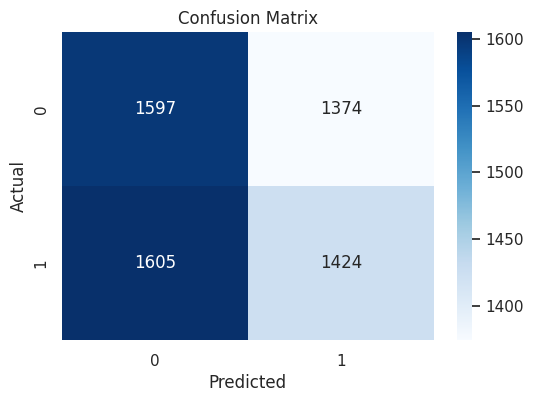

In [6]:
# Predictive Modeling
# In this section, we build a predictor to classify if the Federal Rate Change Flag is active.
# We use a RandomForestClassifier to predict 'Federal_Rate_Change_Flag' based on other features.
# Non-numeric or less-useful features like 'Date' are dropped from the predictors.

# Select the target variable
target = 'Federal_Rate_Change_Flag'

# features: exclude 'Date', 'Federal_Rate_Change_Flag' itself, and any redundant columns if needed
features = df.drop(columns=['Date', target]).columns.tolist()

# For modeling, handle potential missing values by filling them with the mean (for numeric columns) or mode (if necessary).
# Here we focus on simplicity by filling numeric columns with their mean values.
X = df[features].select_dtypes(include=[np.number]).fillna(df.mean())
y = df[target].fillna(0).astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and train the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f'Prediction accuracy for Federal_Rate_Change_Flag: {accuracy:.2f}')

# Display a confusion matrix using a heatmap for clarity
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Summary and Future Work

In this notebook, we explored a multifaceted dataset combining market trend indicators with external factors such as economic news, sentiment scores, and geopolitical risk. We began with a comprehensive data cleaning and visualization phase, ensuring that numerical data was properly plotted using dynamic subplot configuration. The adjustment of the grid layout successfully resolved the error encountered when the number of subplots exceeded the fixed grid limit.

Moving forward, future work might include:

- Time series analysis to forecast future market movements, leveraging the Date column in more sophisticated ways.
- Advanced feature engineering to extract lag features or rolling statistics which may improve predictive accuracy.
- Experimenting with alternative machine learning models and ensemble methods or using deep learning approaches for regression or classification tasks.

If you found this notebook insightful, please consider upvoting it.